# Summary

This notebook uses volume projections and create training-ready data on the following format :

- `patches1` : patches extracted from a rotated version of a projection (target)
- `patches2` : translated patches from each element of `patches1` (source)
- `big_images` : the projection from which patches are extracted
- `transformations` : contains the translation data, as well as the rotation angle for each element of `big_images`
- `rotations` : contains the rotation center for each element of `big_images`

# Options

You can manipulate several options in the next cell to fit different needs.

In [1]:
NB_PATCHES = 50       # Number of generated patches per base image
PATCH_SIZE = 150      # Size of generated patches, in pixels

ROTATION = True       # Whether or not to rotate images
TRANSLATION = True   # Whether or not to translate patches

# Imports & annex functions

## Imports

In [2]:
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
import os

from math import cos, sin
from PIL import Image
from random import randint
from torchvision.transforms.functional import affine

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Parameters
IN_DIR = "/content/drive/MyDrive/PFEE/00 - DATA/IN/ABD_LYMPH_001_proj"  # CAUTION : no "/"
OUT_DIR = "/content/drive/MyDrive/PFEE/00 - DATA/OUT"
IMG_EXT = "png"

## Annex functions

In [5]:
def rotate_image(image, angle, image_center):
    new_center = (image_center[1], image_center[0])
    rot_mat = cv2.getRotationMatrix2D(new_center, angle, 1.0)
    result = cv2.warpAffine(src=image, M=rot_mat, dsize=image.shape[::-1])
    return result

def translate_image(image, x, y):
    translation_matrix = np.float32([ [1,0,x], [0,1,y] ])
    img_translation = cv2.warpAffine(image, translation_matrix, image.shape[1::-1])
    return img_translation

In [6]:
def generate_patch1(img, size):
    patch = np.zeros((size, size))
    while np.count_nonzero(patch) < (size**2 // 2):
        i = randint(size, img.shape[0] - size)
        j = randint(size, img.shape[1] - size)
        patch = img[i:i+size, j:j+size]
    patch = cv2.resize(patch, (PATCH_SIZE, PATCH_SIZE), interpolation=cv2.INTER_CUBIC)
    return patch, (i, j)

def generate_patch2(img, p1_pos, p1_shape, psize):
    rng = psize//5
    if ROTATION:
        values = np.arange(-30, 31, 1)
        theta = np.random.choice(values[~np.in1d(values, [0])])
    else:
        theta = 0
    patch = np.zeros((2,2))
    p2_pos = (-1, -1)
    while patch.shape != p1_shape:
      if TRANSLATION:
          values = np.arange(-30, 31, 1)
          t_x, t_y = np.random.choice(values[~np.in1d(values, [0])]), np.random.choice(values[~np.in1d(values, [0])])
      else:
          t_x, t_y = 0, 0
      p2_pos = (p1_pos[0] + t_y, p1_pos[1] + t_x)
      p2_center = (p2_pos[0]+psize//2, p2_pos[1]+psize//2)
      transformed = rotate_image(img, theta, p2_center)
      patch = transformed[p2_pos[0]:p2_pos[0]+psize, p2_pos[1]:p2_pos[1]+psize]

    patch = cv2.resize(patch, (150, 150), interpolation=cv2.INTER_CUBIC)
    return patch, p2_pos, t_x, t_y, theta, transformed, p2_center

# Main function

In [7]:
os.listdir(IN_DIR)[:10]

['proj0000.png',
 'proj0001.png',
 'proj0002.png',
 'proj0003.png',
 'proj0004.png',
 'proj0006.png',
 'proj0005.png',
 'proj0007.png',
 'proj0008.png',
 'proj0009.png']

(65, 1000, 1000)
/content/drive/MyDrive/PFEE/00 - DATA/IN/ABD_LYMPH_001_proj/proj0010.png 1.0


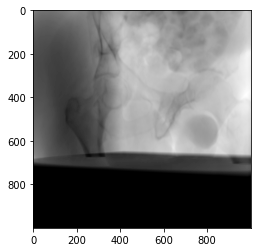

In [8]:
# Load base images into NumPy array
filelist = glob.glob(f"{IN_DIR}/*.{IMG_EXT}")
assert(len(filelist) > 0)
base_imgs = np.array([np.array(Image.open(fname)) for fname in filelist]).astype(np.float32)
base_imgs /= np.amax(base_imgs)

print(base_imgs.shape)
print(filelist[10], np.max(base_imgs[10]))
plt.imshow(base_imgs[30], cmap="gray")

In [9]:
from skimage.transform import resize, rescale

# Generate data
patches1 = []
patches2 = []
big_images_rotated = []
rotations = []
transformations = []

# Debug data
indices = np.random.randint(0, base_imgs.shape[0], base_imgs.shape[0] // 2)

for i, index in enumerate(indices):
    """
    - generate patch1
    - rotate base image
    - generate patch2 according to patch1's position (in rotated image)
    - express transformation from patch2's viewpoint
    """
    print("Index :", index)
    img = base_imgs[index]
    w = img.shape[0]
    h = img.shape[1]
    
    # Generate patch 1
    print("Generate patch 1...")
    patch1, p1_pos = generate_patch1(img, size=PATCH_SIZE)

    # Generate patches 2
    print("Generate patches 2...")
    for _ in range(NB_PATCHES):
        # Get patch 2
        (
            patch2,
            p2_pos,
            t_x,
            t_y,
            theta,
            big_image_rotated,
            center
        ) = generate_patch2(img, p1_pos, patch1.shape, PATCH_SIZE)
  
        # Save
        patches1.append(patch1)
        patches2.append(patch2)
        rotations.append(center)
        transformations.append([-theta, -t_x, -t_y])
        big_images_rotated.append(big_image_rotated)

Index : 10
Generate patch 1...
Generate patches 2...
Index : 14
Generate patch 1...
Generate patches 2...
Index : 8
Generate patch 1...
Generate patches 2...
Index : 5
Generate patch 1...
Generate patches 2...
Index : 52
Generate patch 1...
Generate patches 2...
Index : 8
Generate patch 1...
Generate patches 2...
Index : 8
Generate patch 1...
Generate patches 2...
Index : 39
Generate patch 1...
Generate patches 2...
Index : 23
Generate patch 1...
Generate patches 2...
Index : 58
Generate patch 1...
Generate patches 2...
Index : 56
Generate patch 1...
Generate patches 2...
Index : 46
Generate patch 1...
Generate patches 2...
Index : 0
Generate patch 1...
Generate patches 2...
Index : 49
Generate patch 1...
Generate patches 2...
Index : 21
Generate patch 1...
Generate patches 2...
Index : 29
Generate patch 1...
Generate patches 2...
Index : 0
Generate patch 1...
Generate patches 2...
Index : 23
Generate patch 1...
Generate patches 2...
Index : 52
Generate patch 1...
Generate patches 2...

In [ ]:
big_images_rotated = np.stack(big_images_rotated)
transformations = np.stack(transformations)
rotations = np.stack(rotations)
patches2 = np.stack(patches2)
patches1 = np.stack(patches1)

In [ ]:
print(big_images_rotated.shape)
print(patches1.shape)
print(patches2.shape)
print(transformations.shape)
print(rotations.shape)

# Tests, display

In [ ]:
PROJECTION_I = 5
PATCH_I = 25
INDEX = PROJECTION_I * PATCH_I

# FIXME

transform = transformations[INDEX]
print(transformations[INDEX])
patch1_test = patches1[5]
big_image_rotated = big_images_rotated[INDEX]
big_image_before = rotate_image(big_image_rotated, transform[0], tuple(rotations[INDEX]))
patch2_test = big_image_before[rotations[INDEX][0] - 125 + transform[2]:rotations[INDEX][0] + 125 + transform[2], rotations[INDEX][1] - 125 + transform[1]:rotations[INDEX][1] + 125 + transform[1]]
patch2_without_translation = big_image_before[rotations[INDEX][0] - 125:rotations[INDEX][0] + 125, rotations[INDEX][1] - 125:rotations[INDEX][1] + 125]

fig, ax = plt.subplots(1, 5, figsize =(24, 10))
ax[0].imshow(patch1_test, cmap='gray')
ax[1].imshow(big_image_rotated, cmap='gray')
ax[2].imshow(patches2[INDEX], cmap='gray')
ax[3].imshow(big_image_before, cmap='gray')
ax[4].imshow(patch2_test, cmap='gray')

In [ ]:
#print(f"Base img : min : {np.min(base_imgs[IMG_I])}, max : {np.max(base_imgs[IMG_I])}")
#print(f"Rotated img : min : {np.min(rotated[IMG_I])}, max : {np.max(rotated[IMG_I])}")
#print(f"Patch 1 : min : {np.min(patches1[IMG_I])}, max : {np.max(patches1[IMG_I])}")
#print(f"Patch 2 : min : {np.min(patches2[IMG_I])}, max : {np.max(patches2[IMG_I])}")
#print(f"Reconstruction : min : {np.min(repatches1[IMG_I])}, max : {np.max(repatches1[IMG_I])}")

# Data export

In [ ]:
from datetime import datetime

now = datetime.now()
date_str = now.strftime("%d-%m-%Y_%H:%M:%S")
print("Date :", date_str)

In [ ]:
# Export data
np.save(f"{OUT_DIR}/{date_str}_big_images.npy", big_images_rotated)
np.save(f"{OUT_DIR}/{date_str}_patches1.npy", patches1)
np.save(f"{OUT_DIR}/{date_str}_patches2.npy", patches2)
np.save(f"{OUT_DIR}/{date_str}_transformations.npy", transformations)
np.save(f"{OUT_DIR}/{date_str}_rotations.npy", rotations)